<a href="https://colab.research.google.com/github/rhiosutoyo/Teaching-Deep-Learning-and-Its-Applications/blob/main/11_2_summarizer_using_IndoBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summarizer using IndoBERT

This Python code implements a deep learning model for text summarization using the BERT-based `EncoderDecoderModel` from the Hugging Face Transformers library.
* The script is designed to process a subset of the IMDB dataset, where movie reviews are summarized by truncating them to a specified number of words.
* The model is trained using a custom dataset class that handles tokenization and encoding of input and summary sequences.
* The training process is enhanced with an early stopping mechanism to prevent overfitting by monitoring the validation loss and halting training when no improvement is detected after a specified number of epochs.
* The script also includes functions to visualize training and validation loss over epochs, providing insights into the model's learning process.

The overall goal of the code is to demonstrate a practical approach to text summarization using modern NLP techniques with an emphasis on efficient training and model evaluation.

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, EncoderDecoderModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset and use a smaller subset
url = "https://raw.githubusercontent.com/rhiosutoyo/Teaching-Deep-Learning-and-Its-Applications/main/dataset/IMDB%20Dataset.csv"
data = pd.read_csv(url)
data = data.dropna().reset_index(drop=True)
data = data.sample(n=1000, random_state=42)  # Use only 1000 samples

# Simple summarization by truncating the first 30 words
data['summary'] = data['review'].apply(lambda x: ' '.join(x.split()[:30]))

# Preprocessing
class SummarizationDataset(Dataset):
    def __init__(self, reviews, summaries, tokenizer, max_len):
        self.reviews = reviews
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = str(self.reviews.iloc[index])
        summary = str(self.summaries.iloc[index])

        inputs = self.tokenizer.encode_plus(
            review,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        summary_ids = self.tokenizer.encode(
            summary,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        ).flatten()

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'summary_ids': summary_ids
        }

# Tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = EncoderDecoderModel.from_encoder_decoder_pretrained('bert-base-uncased', 'bert-base-uncased')

# Set decoder start token id and bos token id
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.bos_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.sep_token_id

# Prepare dataset
max_len = 64
batch_size = 8

train_reviews, val_reviews, train_summaries, val_summaries = train_test_split(
    data['review'], data['summary'], test_size=0.2, random_state=42)

train_dataset = SummarizationDataset(train_reviews, train_summaries, tokenizer, max_len)
val_dataset = SummarizationDataset(val_reviews, val_summaries, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=3):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            summary_ids = batch['summary_ids'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=summary_ids)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            progress_bar.set_postfix({"train_loss": total_train_loss / len(train_loader)})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                summary_ids = batch['summary_ids'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=summary_ids)
                loss = outputs.loss
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Validation Loss: {avg_val_loss:.4f}")

        # Early Stopping Mechanism
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0  # Reset counter if we get a better result
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered. No improvement for {patience} consecutive epochs.")
                break

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert

Validation Loss: 4.3106


Epoch 2/10: 100%|██████████| 100/100 [00:13<00:00,  7.40batch/s, train_loss=4.15]


Validation Loss: 4.1370


Epoch 3/10: 100%|██████████| 100/100 [00:13<00:00,  7.56batch/s, train_loss=3.83]


Validation Loss: 3.5801


Epoch 4/10: 100%|██████████| 100/100 [00:13<00:00,  7.57batch/s, train_loss=3.31]


Validation Loss: 3.2612


Epoch 5/10: 100%|██████████| 100/100 [00:13<00:00,  7.55batch/s, train_loss=3.01]


Validation Loss: 3.1121


Epoch 6/10: 100%|██████████| 100/100 [00:13<00:00,  7.50batch/s, train_loss=2.77]


Validation Loss: 3.0274


Epoch 7/10: 100%|██████████| 100/100 [00:13<00:00,  7.57batch/s, train_loss=2.55]


Validation Loss: 2.9869


Epoch 8/10: 100%|██████████| 100/100 [00:13<00:00,  7.56batch/s, train_loss=2.34]


Validation Loss: 2.9362


Epoch 9/10: 100%|██████████| 100/100 [00:13<00:00,  7.57batch/s, train_loss=2.14]


Validation Loss: 2.9163


Epoch 10/10: 100%|██████████| 100/100 [00:13<00:00,  7.57batch/s, train_loss=1.93]


Validation Loss: 2.8974


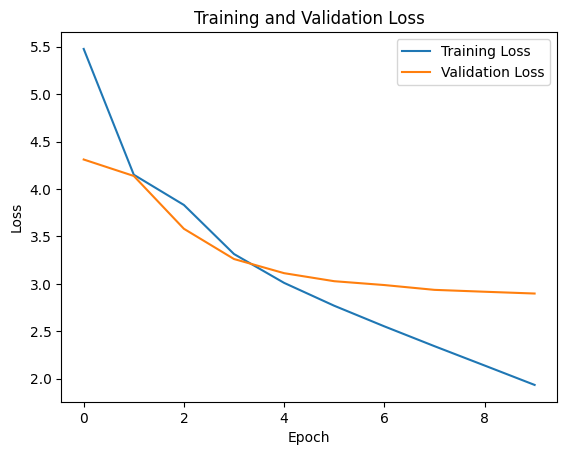

In [2]:
# Plotting results
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [15]:
# Testing
def summarize_text(model, tokenizer, text, max_len=64):
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        return_token_type_ids=False,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    summary_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=50,
        decoder_start_token_id=model.config.decoder_start_token_id
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def print_summary(summary, text):
    print("Summary:\n", summary)
    print("\nOriginal Text:", text)

In [16]:
# Test the model
long_review = """
Tarzan is a captivating adaptation of Edgar Rice Burroughs’ classic tale, bringing the legendary character of Tarzan to life in a visually stunning and emotionally resonant way. Directed by Kevin Lima and Chris Buck, the movie stands out not just for its animation, but also for its deeply engaging narrative, memorable characters, and powerful musical score.
The story begins with a shipwreck that leaves an infant boy orphaned on the coast of Africa. He is discovered by Kala, a kind-hearted gorilla, who has recently lost her own child. Despite the protests of her mate, Kerchak, the leader of the gorilla troop, Kala adopts the boy and names him Tarzan. The film then follows Tarzan’s journey as he grows up in the jungle, raised by gorillas, and learns to survive in the wild, eventually becoming one with the animals around him.
What makes Tarzan truly special is its exploration of identity and belonging. Tarzan is a human raised among apes, caught between two worlds. He is different from the gorillas, yet he feels a deep connection to them, especially to Kala, who is the only mother he has ever known. This conflict is beautifully portrayed through the animation, which captures Tarzan’s struggle to reconcile his dual nature – a man with the instincts and abilities of an ape. The scenes where he swings through the trees with the grace and speed of a gorilla are breathtaking, showcasing the animation team’s attention to detail and their ability to bring Burroughs’ jungle hero to life.
The movie’s emotional core is amplified by the voice acting, particularly from Tony Goldwyn as Tarzan and Minnie Driver as Jane. Goldwyn’s Tarzan is a complex character, full of curiosity, strength, and vulnerability. Driver’s Jane is a delightful counterpart – intelligent, adventurous, and compassionate. The chemistry between Tarzan and Jane is palpable, and their growing relationship is one of the highlights of the film. Jane’s introduction to the jungle is both comedic and touching, as she navigates the unfamiliar terrain with Tarzan’s help, leading to some of the movie’s most endearing moments.
Phil Collins’ musical score is another standout aspect of the film. Songs like “You’ll Be in My Heart” and “Son of Man” are not just background music but integral parts of the narrative, enhancing the emotional depth of the story. Collins’ voice, combined with the sweeping orchestral arrangements, captures the essence of Tarzan’s journey from boyhood to manhood, and from isolation to love. The music plays a crucial role in conveying the film’s themes of family, self-discovery, and the bonds that transcend differences.
The supporting characters are also well-developed, each contributing to the richness of the story. Kala, voiced by Glenn Close, embodies maternal love and strength, while Kerchak, voiced by Lance Henriksen, represents authority and the challenges of leadership. The antagonist, Clayton, voiced by Brian Blessed, is a ruthless hunter whose greed and lack of respect for the jungle ultimately lead to his downfall. His character serves as a stark contrast to Tarzan, highlighting the theme of coexistence versus domination.
The animation itself is a marvel, blending traditional hand-drawn techniques with cutting-edge CGI to create a lush, immersive jungle environment. The animators used a process called “Deep Canvas” to give the backgrounds a sense of depth and movement, allowing for dynamic, fast-paced action sequences that are both thrilling and visually stunning. The jungle is alive with detail – from the rustling of leaves to the movement of animals – making the setting as much a character in the film as Tarzan or Jane.
However, what truly elevates Tarzan is its heart. At its core, this is a story about family, love, and finding one’s place in the world. Tarzan’s journey of self-discovery is something that resonates with audiences of all ages. He starts as a boy who doesn’t quite fit in, struggling to understand who he is and where he belongs. Through his experiences and relationships, particularly with Jane and Kala, he learns that his worth is not defined by his origins but by his actions and the love he gives and receives.
In conclusion, Tarzan is more than just an animated adventure; it’s a poignant tale about identity, belonging, and the enduring power of love. With its compelling narrative, stunning animation, memorable characters, and a soundtrack that tugs at the heartstrings, Tarzan is a timeless classic that continues to resonate with audiences more than two decades after its release. It is a must-watch for anyone who appreciates a well-told story, beautiful animation, and a movie with genuine emotional depth.
"""

summary = summarize_text(model, tokenizer, long_review)
print_summary(summary, long_review)

Summary:
 the story of the film is a masterpiece of the pioneers of the islamic era. the story of the pioneers of the pioneers's story is a masterpiece of art, and

Original Text: 
Tarzan is a captivating adaptation of Edgar Rice Burroughs’ classic tale, bringing the legendary character of Tarzan to life in a visually stunning and emotionally resonant way. Directed by Kevin Lima and Chris Buck, the movie stands out not just for its animation, but also for its deeply engaging narrative, memorable characters, and powerful musical score.
The story begins with a shipwreck that leaves an infant boy orphaned on the coast of Africa. He is discovered by Kala, a kind-hearted gorilla, who has recently lost her own child. Despite the protests of her mate, Kerchak, the leader of the gorilla troop, Kala adopts the boy and names him Tarzan. The film then follows Tarzan’s journey as he grows up in the jungle, raised by gorillas, and learns to survive in the wild, eventually becoming one with the anim

In [17]:
# Test the model
lord_of_the_rings_review = """
The Lord of the Rings is an epic cinematic achievement that has firmly established itself as one of the greatest film trilogies in history. Directed by Peter Jackson and based on J.R.R. Tolkien's monumental literary work, the film trilogy consists of three parts: The Fellowship of the Ring, The Two Towers, and The Return of the King. Each installment builds upon the last, creating a sweeping narrative that is both grand in scope and deeply personal in its exploration of courage, friendship, and the eternal struggle between good and evil.
The story is set in the fantastical world of Middle-earth, a land inhabited by a rich tapestry of characters, including hobbits, elves, dwarves, wizards, and men. At the heart of the narrative is the One Ring, a powerful artifact created by the dark lord Sauron to dominate all life in Middle-earth. The Ring, however, is lost for centuries until it is found by a hobbit named Bilbo Baggins. The responsibility of destroying the Ring falls to Bilbo's young nephew, Frodo Baggins, who must journey to the fires of Mount Doom, the only place where the Ring can be destroyed.
The Fellowship of the Ring introduces us to the main characters and the formation of the Fellowship, a group of nine individuals representing different races of Middle-earth who vow to aid Frodo in his quest. The film masterfully sets the stage for the epic journey, with stunning visuals of the Shire, Rivendell, and the Mines of Moria. The tension and stakes are established early on, with the looming presence of Sauron's forces and the internal struggles within the Fellowship itself.
The Two Towers delves deeper into the characters' development and the growing sense of despair as the Fellowship is broken, and the members are scattered across Middle-earth. The film is darker and more intense, with the introduction of new characters such as the treacherous Gollum, brilliantly portrayed by Andy Serkis through groundbreaking motion capture technology. Gollum's internal conflict, driven by his obsession with the Ring, adds a layer of complexity to the story. The film also features the epic Battle of Helm's Deep, a visually stunning and emotionally charged sequence that stands as one of the greatest battle scenes in cinematic history.
The Return of the King, the final installment, brings the story to a triumphant and emotionally satisfying conclusion. The film's grandeur is unmatched, with awe-inspiring sequences such as the Siege of Minas Tirith and the Battle of the Pelennor Fields. The stakes are at their highest, and the characters are pushed to their limits. The emotional weight of Frodo's journey, the sacrifices made by Aragorn, Gandalf, and the rest of the Fellowship, and the ultimate victory over Sauron resonate deeply with the audience. The film culminates in the destruction of the Ring and the restoration of peace to Middle-earth, but not without a poignant reflection on the cost of the journey and the toll it has taken on the characters.
The Lord of the Rings trilogy is not just a technical and visual masterpiece but also a deeply human story that resonates on a personal level. The themes of friendship, loyalty, sacrifice, and the fight against overwhelming odds are universal and timeless. The relationships between the characters, particularly the bond between Frodo and Sam, are at the heart of the trilogy and provide the emotional anchor for the epic narrative. Sean Astin's portrayal of Samwise Gamgee, in particular, is a standout, bringing a warmth and sincerity to the role that makes his character one of the most beloved in the series.
The performances of the entire cast are exceptional, with Elijah Wood as the determined yet vulnerable Frodo, Viggo Mortensen as the noble and courageous Aragorn, Ian McKellen as the wise and powerful Gandalf, and Cate Blanchett as the ethereal Galadriel. The supporting cast, including Orlando Bloom as Legolas, John Rhys-Davies as Gimli, and Liv Tyler as Arwen, all bring their characters to life with depth and authenticity.
The technical achievements of the trilogy cannot be overstated. The use of practical effects, miniatures, and CGI are seamlessly integrated to create the rich and immersive world of Middle-earth. The attention to detail in the set design, costumes, and props is astounding, making the world feel lived-in and real. The score by Howard Shore is iconic, with themes that have become synonymous with the characters and places in the story. The music elevates the emotional impact of the film, from the haunting beauty of "The Shire" to the rousing and heroic "Rohan."
Peter Jackson's direction is masterful, balancing the epic scale of the story with intimate character moments. He brings Tolkien's world to life with a vision that is both faithful to the source material and innovative in its execution. The pacing, especially in the extended editions of the films, allows the story to breathe and gives the characters the space to develop fully.
In conclusion, The Lord of the Rings trilogy is a cinematic masterpiece that stands the test of time. It is a monumental achievement in filmmaking that has left an indelible mark on the fantasy genre and on cinema as a whole. The combination of breathtaking visuals, compelling storytelling, and deeply resonant themes make it a timeless classic that continues to captivate audiences. Whether you are a longtime fan or a newcomer to Middle-earth, The Lord of the Rings is a must-watch, offering a journey that is as profound and moving as it is epic and thrilling.
"""

summary = summarize_text(model, tokenizer, lord_of_the_rings_review)
print_summary(summary, lord_of_the_rings_review)

Summary:
 the first trilogy of the trilogy of the trilogy trilogy of the trilogy trilogy of the trilogy trilogy of the trilogy trilogy of the trilogy trilogy of the trilogy trilogy of the trilogy trilogy trilogy trilogy trilogy trilogy trilogy trilogy trilogy trilogy trilogy trilogy trilogy trilogy trilogy trilogy

Original Text: 
The Lord of the Rings is an epic cinematic achievement that has firmly established itself as one of the greatest film trilogies in history. Directed by Peter Jackson and based on J.R.R. Tolkien's monumental literary work, the film trilogy consists of three parts: The Fellowship of the Ring, The Two Towers, and The Return of the King. Each installment builds upon the last, creating a sweeping narrative that is both grand in scope and deeply personal in its exploration of courage, friendship, and the eternal struggle between good and evil.
The story is set in the fantastical world of Middle-earth, a land inhabited by a rich tapestry of characters, including hob

In [18]:
the_godfather_review = """
The Godfather is an enduring masterpiece of American cinema, directed by Francis Ford Coppola and based on the novel by Mario Puzo. Released in 1972, the film has become a cultural touchstone, celebrated for its powerful storytelling, complex characters, and its profound exploration of the themes of power, family, and loyalty. It is a film that transcends the crime genre, offering a compelling portrait of the human condition within the context of organized crime.
The story of The Godfather centers on the powerful and secretive Corleone family, an Italian-American mafia clan based in New York. At the head of the family is Vito Corleone, portrayed with quiet authority by Marlon Brando in one of the most iconic performances in film history. Vito is both a feared crime lord and a loving father, embodying the duality of his role as both a protector of his family and a ruthless enforcer of his will. Brando’s performance, marked by his distinctive voice and understated yet commanding presence, anchors the film and gives the character of Vito Corleone an almost mythic stature.
The film’s narrative arc follows the transformation of Vito’s youngest son, Michael Corleone, played by Al Pacino, from a reluctant outsider to the ruthless head of the family. Michael begins the film as a war hero, seemingly uninterested in the family’s criminal enterprises. However, as the story progresses, Michael is drawn deeper into the family’s world of violence and power, ultimately taking over as the Godfather after Vito’s death. Pacino’s performance is nothing short of extraordinary, capturing Michael’s evolution from an idealistic young man to a cold, calculating mafia boss. His gradual transformation is one of the film’s most compelling elements, showing how power can corrupt even the most principled individuals.
The Godfather is also notable for its exploration of the concept of family, both as a source of strength and as a burden. The Corleone family is depicted as a tightly knit unit, bound together by loyalty and tradition, yet also torn apart by the very power that sustains it. The relationships between the family members are complex and layered, particularly between Vito and his sons. The film delves into the ways in which the family’s criminal activities affect their personal lives, with devastating consequences. This exploration of family dynamics adds a rich emotional depth to the film, making it much more than just a crime drama.
One of the most remarkable aspects of The Godfather is its moral ambiguity. The film does not present its characters as simply good or evil, but rather as complex individuals navigating a world where the lines between right and wrong are often blurred. Vito Corleone, for instance, is a man who commands respect and loyalty through fear and violence, yet he is also shown as a loving father and a man of honor who values loyalty and justice. This duality makes the characters relatable and human, even as they commit acts of brutality.
The supporting cast of The Godfather is equally impressive, with standout performances from James Caan as the hot-headed Sonny Corleone, Robert Duvall as the loyal family consigliere Tom Hagen, and Diane Keaton as Michael’s wife, Kay Adams, who becomes increasingly disillusioned with her husband’s descent into the world of crime. Each actor brings depth and nuance to their roles, contributing to the film’s rich tapestry of characters.
Visually, The Godfather is a triumph. Cinematographer Gordon Willis, known as the “Prince of Darkness,” uses light and shadow to create a mood of foreboding and tension throughout the film. The use of dim lighting, particularly in the scenes set inside the Corleone family’s home, adds to the sense of secrecy and danger that permeates the story. The film’s visual style is both beautiful and haunting, perfectly complementing its dark themes.
The Godfather is also renowned for its memorable dialogue and iconic scenes. Lines such as “I’m gonna make him an offer he can’t refuse” and “Leave the gun, take the cannoli” have become part of the cultural lexicon, emblematic of the film’s ability to blend the brutal with the banal. The film’s pacing is deliberate, allowing the tension to build gradually, culminating in moments of shocking violence that are all the more impactful for their suddenness.
The film’s score, composed by Nino Rota, is another key element of its success. The hauntingly beautiful main theme, with its mournful trumpet melody, perfectly encapsulates the film’s blend of tragedy and grandeur. The music is integral to the film’s emotional impact, underscoring the themes of loss, betrayal, and the inexorable pull of destiny.
The Godfather’s influence on cinema cannot be overstated. It has inspired countless filmmakers and has left an indelible mark on popular culture. Its portrayal of the mafia has become the definitive representation in film, influencing how organized crime is depicted in media to this day. Beyond its impact on the genre, The Godfather is a film that has resonated with audiences for decades because of its universal themes of power, corruption, and the complexities of family.
In conclusion, The Godfather is more than just a great movie; it is a cultural phenomenon. Its combination of masterful storytelling, unforgettable performances, and technical brilliance has secured its place as one of the greatest films of all time. Whether you are watching it for the first time or the fiftieth, The Godfather remains an engrossing, powerful experience that continues to captivate audiences. It is a timeless classic that speaks to the human condition and the dark side of the American dream.
"""

summary = summarize_text(model, tokenizer, the_godfather_review)
print_summary(summary, the_godfather_review)

Summary:
 the film is a film of the 1960s film maker, the director of the 1960s film industry, and is a landmark film, and is a landmark film. the film is a landmark,

Original Text: 
The Godfather is an enduring masterpiece of American cinema, directed by Francis Ford Coppola and based on the novel by Mario Puzo. Released in 1972, the film has become a cultural touchstone, celebrated for its powerful storytelling, complex characters, and its profound exploration of the themes of power, family, and loyalty. It is a film that transcends the crime genre, offering a compelling portrait of the human condition within the context of organized crime.
The story of The Godfather centers on the powerful and secretive Corleone family, an Italian-American mafia clan based in New York. At the head of the family is Vito Corleone, portrayed with quiet authority by Marlon Brando in one of the most iconic performances in film history. Vito is both a feared crime lord and a loving father, embodying the 

# Suggested Activity
Please increase the number of epoch (e.g., epoch = 100) to trigger the early stopping mechanism.